In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm import tqdm
from time import time

In [145]:
def create_subgraphs():
    """
    Creates subgraphs of the Higgs dataset with the full timestamps
    :return: nothing
    """
    activity_time_path = "../network-data/higgs-activity_time.txt"
    activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['target', 'source', 'time', 'type'])

    # create high resolution timestamped datasets
    reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
    mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
    retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

    activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
    # activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
    # .to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)
    # Swap source and target columns in the retweet dataset to effectively simulate the dataflow (as mentioned on the website)
    activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    if isinstance(G, nx.DiGraph):
        return G.subgraph(max(nx.weakly_connected_components(G), key=len))
    else:
        return G.subgraph(max(nx.connected_components(G), key=len))

def build_df_from_graph(graph, bin_size=60*60):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'timestamp' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['time'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['timestamp'] = ((graph_df['timestamp'] - min_t) / bin_size).astype(int)
    # subgraph_df['timestamp'] = ((subgraph_df['timestamp'] - min_t)).astype(int)
    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df = graph_df.sort_values(by=['timestamp'])
    graph_df.reset_index(drop=True, inplace=True)

    return graph_df

def build_social_network_df(graph):
    social_network_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
        # Drop the 'attribute' column, which is no longer needed
    social_network_df.drop('attribute', axis=1, inplace=True)
    social_network_df = social_network_df.drop_duplicates()
    return social_network_df

def simulate_spreading(graph_df, social_network_df, seed_node, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name="name_not_given", plot=True):

    graph_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
#     print(graph_df['source'].unique())
    #print(np.concatenate((np.array(graph_df['source'].unique()), np.array(graph_df['target'].unique()))))
    graph_nodes[np.concatenate((np.array(graph_df['source'].unique()), np.array(graph_df['target'].unique())))] = 1
    
    social_network_np = social_network_df.to_numpy()

    spreading_start_time = graph_df[graph_df['source'] == seed_node]['timestamp'].min()
    min_timestamp = start_timestamp
    max_timestamp = end_timestamp
    # Get the number of nodes in the graph
    infected_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)

    informed_nodes =  np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    infected_nodes_time = [infected_nodes.sum()/number_of_component_nodes]
    informed_nodes_time = [informed_nodes.sum()/number_of_total_nodes]
    # Iterate over all timestamps
    for timestamp in range(min_timestamp, max_timestamp+1):
        if timestamp == spreading_start_time:
            infected_nodes[seed_node] = 1
            informed_nodes[seed_node] = 1
            informed_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1
            infected_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1
            infected_nodes *= graph_nodes
        print(f'Graph: {name} Timestamp: {timestamp}/{max_timestamp} --- ', end='\r')

        # For each timestamp get the edges that were created on that timestamp
        edges = graph_df[graph_df['timestamp'] == timestamp]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes= edges[(infected_nodes[edges['source']] == 1) |(informed_nodes[edges['source']] == 1)  ]['target']
        # Add the susceptible nodes to the infected nodes
        infected_nodes[susceptible_nodes] = 1
        infected_nodes *= graph_nodes
        # Add nodes to the informed nodes that are connected to the infected nodes
        susceptible_informed_nodes = social_network_df[social_network_df['target'].isin(susceptible_nodes)]['source']
        informed_nodes[susceptible_informed_nodes] = 1
        
#         sus_series = pd.Series(susceptible_nodes, name='target')
        
#         susceptible_informed_nodes = social_network_df.merge(sus_series, on='target', how='inner')['source']
#         informed_nodes[susceptible_informed_nodes] = 1
        
#         susceptible_informed_nodes = social_network_np[np.isin(social_network_np[:, 1], susceptible_nodes)][:, 0]
#         informed_nodes[susceptible_informed_nodes] = 1
        
        # Add the infected and informed nodes to the infected_nodes_time_dict
        infected_nodes_time.append(infected_nodes.sum()/number_of_component_nodes)
        informed_nodes_time.append(informed_nodes.sum()/number_of_total_nodes)

    if plot:
        plt.plot(np.arange(min_timestamp, max_timestamp+2), infected_nodes_time, label=f'{name}' + ' infected nodes', alpha=0.8)
        plt.plot(np.arange(min_timestamp, max_timestamp+2), informed_nodes_time, label=f'{name}' + ' informed nodes', alpha=0.8)
        plt.legend()
    return infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time

def get_start_end_combined(subgraph_reply_df, subgraph_mention_df, subgraph_retweet_df):
    start_timestamp_reply = min(subgraph_reply_df['timestamp'])
    start_timestamp_mention = min(subgraph_mention_df['timestamp'])
    start_timestamp_retweet = min(subgraph_retweet_df['timestamp'])
    end_timestamp_reply = max(subgraph_reply_df['timestamp'])
    end_timestamp_mention = max(subgraph_mention_df['timestamp'])
    end_timestamp_retweet = max(subgraph_retweet_df['timestamp'])

    start_timestamp = min(start_timestamp_reply, start_timestamp_mention, start_timestamp_retweet)
    end_timestamp = max(end_timestamp_reply, end_timestamp_mention, end_timestamp_retweet)
    return start_timestamp, end_timestamp

In [3]:
create_subgraphs()

In [4]:
G_reply = nx.read_edgelist("../output/reply_timestamps.edgelist", nodetype=int, data=(('time',int),), create_using=nx.DiGraph)
G_mention = nx.read_edgelist("../output/mention_timestamps.edgelist", nodetype=int, data=(('time', int),),  create_using=nx.DiGraph)
G_retweet = nx.read_edgelist("../output/retweet_timestamps.edgelist", nodetype=int, data=(('time', int),), create_using=nx.DiGraph)
G_social = nx.read_edgelist("../network-data/higgs-social_network.edgelist", nodetype=int, create_using=nx.DiGraph)

G_reply_lcc = largest_connected_component(G_reply)
G_mention_lcc = largest_connected_component(G_mention)
G_retweet_lcc = largest_connected_component(G_retweet)

In [5]:
G_reply_lcc_df = build_df_from_graph(G_reply_lcc)
G_mention_lcc_df = build_df_from_graph(G_mention_lcc)
G_retweet_lcc_df = build_df_from_graph(G_retweet_lcc)

In [6]:
G_reply_df = build_df_from_graph(G_reply)
G_mention_df = build_df_from_graph(G_mention)
G_retweet_df = build_df_from_graph(G_retweet)

In [7]:
G_social_df = build_social_network_df(G_social)

In [8]:
print(G_retweet_lcc)
print(G_mention_lcc)
print(G_reply_lcc)
print(G_social)

DiGraph with 223833 nodes and 308596 edges
DiGraph with 91606 nodes and 132068 edges
DiGraph with 12839 nodes and 14944 edges
DiGraph with 456626 nodes and 14855842 edges


In [156]:
def get_subgraph(G, max_n_of_nodes=None, is_seed_node_most_connected=True, seed = None):
    """
    Returns a subgraph of G with k nodes generated by BFS from a seed node
    :param G: graph
    :param k: number of nodes in the subgraph
    :param is_seed_node_most_connected: whether the seed node is the most connected node or a random node
    :param seed: seed node, random if None
    :return: subgraph
    """
    if max_n_of_nodes is None:
        max_n_of_nodes = G.number_of_nodes() // 5

    if seed:
        seed_node = seed
    elif is_seed_node_most_connected:
        seed_node = max(G.degree(), key=lambda x: x[1])[0]
    else:
        # Choosing a random node does not guarantee getting a subgraph of the desired size
        seed_node = random.choice(list(G.nodes()))
    # Initialize a queue for BFS and a set for visited nodes
    queue = [seed_node]
    visited = set([seed_node])
    # Initialize the subgraph with the starting node
    subgraph = nx.Graph()
    subgraph.add_node(seed_node)
    # While the subgraph has fewer than n nodes and the queue is not empty
    while len(subgraph) < max_n_of_nodes and queue:
        # Get the next node from the queue
        curr_node = queue.pop(0)
        # Add its neighbors that have not been visited to the queue and the subgraph
        for neighbor in G.neighbors(curr_node):
            if len(subgraph) >= max_n_of_nodes:
                break
            visited.add(neighbor)
            subgraph.add_node(neighbor)
            subgraph.add_edge(curr_node, neighbor, day=G[curr_node][neighbor]["time"])
            queue.append(neighbor)
    # print n of nodes in the subgraph 
    print(f"subgraph has {len(subgraph)} nodes")
    return subgraph

In [ ]:
# Start spreading from the node with the maximal out_degree in each of the networks
max_degree_reply = max(G_reply.out_degree(), key=lambda x: x[1])[0]
max_degree_retweet = max(G_retweet.out_degree(), key=lambda x: x[1])[0]
max_degree_mention = max(G_mention.out_degree(), key=lambda x: x[1])[0]
print(G_reply.out_degree(max_degree_reply))
print(G_retweet.out_degree(max_degree_retweet))
print(G_mention.out_degree(max_degree_mention))
# Get the subgraph of the node with the maximum average degree
subgraph_reply = get_subgraph(G_reply, max_n_of_nodes=5000, seed=max_degree_reply)
subgraph_mention = get_subgraph(G_mention, max_n_of_nodes=5000, seed=max_degree_mention)
subgraph_retweet = get_subgraph(G_retweet, max_n_of_nodes=5000, seed=max_degree_retweet)
print(subgraph_retweet)
print(subgraph_mention)
print(subgraph_reply)

1206
14060
169


In [82]:
def get_nodes_by_centrality(network, n_nodes, start=0, metric='degree_out'):
    if metric == 'degree_out':
        centr = G_reply.out_degree()
    if metric == 'degree_in':
        centr = G_reply.in_degree()
    if metric == 'eigen':
        centr = nx.eigenvector_centrality(G_reply)
    return [v[0] for v in sorted(centr, key=lambda x: -x[1])][start:start + n_nodes]

In [10]:
n_nodes = 50
metric = 'degree_in'

max_degree_reply = get_nodes_by_centrality(G_reply, n_nodes)
max_degree_retweet = get_nodes_by_centrality(G_retweet, n_nodes)
max_degree_mention = get_nodes_by_centrality(G_mention, n_nodes)

print(max_degree_reply)

[677, 88, 220, 3549, 317, 349, 1988, 7690, 3369, 16460, 2177, 4368, 2014, 4259, 6940, 5245, 216, 327, 12281, 3998, 9964, 13808, 7962, 1880, 2280, 1574, 511, 14454, 4446, 9021, 16188, 36436, 68278, 5335, 2941, 2353, 3419, 503, 459, 245, 2288, 2417, 408, 16527, 122488, 352, 1276, 13854, 11036, 2347]


In [11]:
start_timestamp, end_timestamp = get_start_end_combined(G_reply_lcc_df, G_mention_lcc_df, G_retweet_lcc_df)
print(start_timestamp)
print(end_timestamp)

0
167


[ 18038 213163  33833 ...  34216 223125  97296]


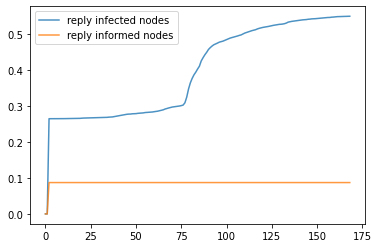

In [12]:
infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(G_reply_lcc_df,\
            G_social_df, max_degree_reply[0], start_timestamp, end_timestamp, len(G_reply_lcc.nodes()),\
            len(G_social.nodes()), name="reply", plot=True)

In [13]:
def simulate_spreading_n_nodes(graph_df, social_network_df, seed_nodes, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name="name_not_given", plot=True):
    
    infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n = [], [], [], []
    
    for node in seed_nodes:
        infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(\
                graph_df, social_network_df, node, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name=name, plot=plot)
        
        infected_nodes_n.append(infected_nodes)
        informed_nodes_n.append(informed_nodes)
        infected_nodes_time_n.append(infected_nodes_time)
        informed_nodes_time_n.append(informed_nodes_time)
        
    return infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n

In [14]:
def cum_to_diff(time):
    return np.array(time[1:]) - np.array(time[:-1])

In [28]:
def get_crosscorr(proc_n_1, proc_n_2):
    return [np.correlate(cum_to_diff(proc_1), cum_to_diff(proc_2), 'full') for proc_1, proc_2 in zip(proc_n_1, proc_n_2)]

In [146]:
_, _, infected_nodes_time_rep, informed_nodes_time_rep = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_degree_reply, start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=False)
_, _, infected_nodes_time_ret, informed_nodes_time_ret = simulate_spreading_n_nodes(G_retweet_lcc_df, G_social_df, max_degree_retweet, start_timestamp, end_timestamp, len(G_retweet_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=False)

KeyboardInterrupt: 

In [17]:
infected_nodes_time_rep, informed_nodes_time_rep = np.array(infected_nodes_time_rep), np.array(informed_nodes_time_rep)
infected_nodes_time_ret, informed_nodes_time_ret = np.array(infected_nodes_time_ret), np.array(informed_nodes_time_ret)

In [124]:
min_x = 
max_x = -1
corr_n = get_crosscorr(np.array(infected_nodes_time_rep)[:, min_x:max_x], np.array(infected_nodes_time_ret)[:, min_x:max_x])

In [125]:
corr_n = np.nan_to_num([c/np.max(c) for c in corr_n[:]])

C:\Users\drobi\AppData\Local\Temp\ipykernel_20668\1895130831.py:1: RuntimeWarning: invalid value encountered in true_divide
  corr_n = np.nan_to_num([c/np.max(c) for c in corr_n[:]])


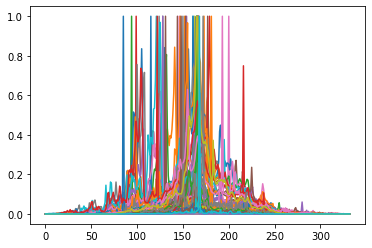

In [126]:
[plt.plot(c) for c in corr_n[:]]
plt.show()

In [127]:
corr = np.mean(corr_n[:], axis=0)

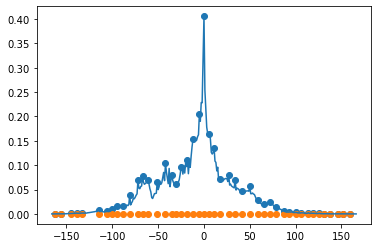

In [128]:
d = len(corr) // 2
plt.plot(np.arange(-d, d + 1), corr)
peaks = find_peaks(corr, distance=5)[0]
plt.scatter(peaks - d, corr[peaks])
plt.scatter(peaks - d, [0]*len(peaks))
# plt.yscale('log')

In [130]:
sorted([(x, y) for x, y in zip(peaks - d, corr[peaks])], key=lambda x: -x[1])

[(0, 0.4056515588928507),
 (-5, 0.205613609475602),
 (6, 0.1629966299896914),
 (-12, 0.1530683164550091),
 (11, 0.13617227407348984),
 (-18, 0.11014866022744513),
 (-42, 0.10362229954018909),
 (-25, 0.09537619135126746),
 (-35, 0.08007298754268413),
 (27, 0.08006576813082779),
 (-67, 0.07798807661299974),
 (17, 0.07259546329981703),
 (34, 0.07052978285387285),
 (-61, 0.06898613000130313),
 (-72, 0.06869277788901326),
 (-51, 0.06621984068486948),
 (-30, 0.06198322338657427),
 (50, 0.05656209691981884),
 (41, 0.046897960981816755),
 (-81, 0.038799425792134364),
 (59, 0.028725884550013955),
 (72, 0.024118030769731544),
 (65, 0.0213139820320495),
 (-95, 0.01719491965076581),
 (-88, 0.01571700632867455),
 (79, 0.01425370236485623),
 (-100, 0.009469632153916977),
 (-115, 0.00756052747483611),
 (87, 0.0059863130242768835),
 (-106, 0.0051650874573547865),
 (93, 0.004425782601683096),
 (100, 0.00319017840621178),
 (114, 0.002409534621036314),
 (106, 0.0024057459676533996),
 (-133, 0.00192413076

In [ ]:
[plt.plot(i) for i in informed_nodes_time_rep[:, cutoff:]]

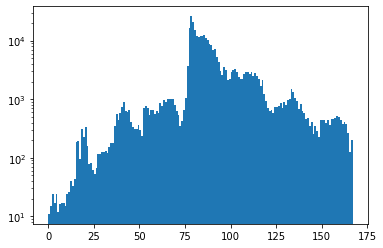

In [129]:
plt.hist(G_retweet_df['timestamp'], bins=167)
plt.yscale('log')